In [ ]:
!pip3 install mne

     |████████████████████████████████| 7.4 MB 7.4 MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split

import mne

import os
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
option = 'dummy'
cond = '-' + option + '_epo'
path = '' # path to files
files = glob.glob(os.path.join(path + '/derivatives/megepochs', option, 'experiment' + '*' + cond + '.fif'))


X = []
y = []
scaler = StandardScaler()
for file in files[1:2]:
    epochs = mne.read_epochs(file, verbose = 'CRITICAL')
    epochs.pick_types(meg='grad')
    epochs.crop(tmax=1)
    X_f = np.swapaxes(epochs.get_data(), 1, 2)
    X_f = scaler.fit_transform(X_f.reshape(-1, X_f.shape[-1])).reshape(X_f.shape)
    X.append(X_f)
    if option == 'task':
      y.append(epochs.events[:, 2])
    elif option == 'dummy':
      y.append(epochs.events[:, 2] / 10)
    elif option == 'cue':
      y.append(epochs.events[:, 2] - 87)


X = tuple(X)
y = tuple(y)
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0) - 1

In [ ]:
class MEGDataset(Dataset):
    def __init__(self,X,y):
      self.X=X
      self.y=y
   
    def __len__(self):
      return len(self.X)
 
    def __getitem__(self,index):
      return self.X[index].float(), self.y[index].float()

In [ ]:
X, X_valid, y, y_valid = train_test_split(X, y,
                                          test_size=0.1,
                                          random_state = 42)

X = Variable(torch.Tensor(X))
X_valid = Variable(torch.Tensor(X_valid))
y = Variable(torch.Tensor(y))
y_valid = Variable(torch.Tensor(y_valid))

In [ ]:
class LSTM1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_layers = num_layers  # number of layers
        self.input_size = input_size  # input size
        self.hidden_size = hidden_size  # hidden state
        self.seq_length = seq_length  # sequence length

        self.dropout = nn.Dropout(p = 0.2)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)  # lstm
        self.fc_1 = nn.Linear(hidden_size, 1)  # fully connected 1
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))  # hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))  # internal state
        # Propagate input through LSTM
        x = self.dropout(x)
        output, (hn, cn) = self.lstm(x, (h_0, c_0))  # lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size)  # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.sigmoid(self.fc_1(out))
        return out.flatten()


def get_accuracy(y_true, y_prob):
    # accuracy = torch.sum(y_true == (y_prob > 0.5)) / y_true.shape[0]
    accuracy = roc_auc_score(y_true, (y_prob > 0.5))
    return accuracy

In [ ]:
class RNN1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length):
        super(RNN1, self).__init__()
        self.num_layers = num_layers  # number of layers
        self.input_size = input_size  # input size
        self.hidden_size = hidden_size  # hidden state

        self.dropout = nn.Dropout(p = 0.2)
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 1)  # fully connected 1
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))  # hidden state

        output, hn = self.rnn(x, h_0)
        hn = hn.view(-1, self.hidden_size)  # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.sigmoid(self.fc_1(out))
        return out.flatten()

In [ ]:
class GRU1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length):
        super(GRU1, self).__init__()
        self.num_layers = num_layers  # number of layers
        self.input_size = input_size  # input size
        self.hidden_size = hidden_size  # hidden state

        self.dropout = nn.Dropout(p = 0.2)
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 1)  # fully connected 1
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))  # hidden state

        x = self.dropout(x)
        output, hn = self.gru(x, h_0)
        hn = hn.view(-1, self.hidden_size)  # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.sigmoid(self.fc_1(out))
        return out.flatten()

In [ ]:
num_epochs = 20
learning_rate = 0.01

input_size = X.shape[-1]
hidden_size = 100
num_layers = 1
batch_size = 250

# model = LSTM1(input_size, hidden_size, num_layers, X.shape[1])
# model = RNN1(input_size, hidden_size, num_layers, X.shape[1])
model = GRU1(input_size, hidden_size, num_layers, X.shape[1])

criterion = torch.nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma = 0.5)

train = MEGDataset(X, y)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

test = MEGDataset(X_valid, y_valid)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [ ]:
losses = []
test_losses = []
accs = []
test_accs = []

for epoch in range(num_epochs):
    i = 0
    running_loss = 0.0
    running_corrects = 0
    for X_batch, y_batch in train_loader:
        i += 1
        optimizer.zero_grad()
        outputs = model.forward(X_batch)

        loss = criterion(outputs, y_batch)
        loss.backward()

        optimizer.step()
        
        running_loss += loss.item() * X_batch.size(0)
        running_corrects += torch.sum(y_batch == (outputs > 0.5))


    epoch_loss = running_loss / X.shape[0]
    epoch_acc = running_corrects.float() / X.shape[0]
    losses.append(epoch_loss)
    accs.append(epoch_acc)

    print("Epoch %d, loss: %1.5f" % (epoch, epoch_loss))
    print("Epoch %d, accuracy: %1.5f" % (epoch, epoch_acc))

    running_test_loss = 0.0
    test_corrects = 0
    for X_batch, y_batch in test_loader:
        i += 1
        outputs = model.forward(X_batch)
        loss = criterion(outputs, y_batch)
        running_test_loss += loss.item() * X_batch.size(0)
        test_corrects += torch.sum(y_batch == (outputs > 0.5))


    epoch_test_loss = running_test_loss / X_valid.shape[0]
    scheduler.step()

    epoch_test_acc = test_corrects.float() / X_valid.shape[0]

    test_accs.append(epoch_test_acc)
    test_losses.append(epoch_test_loss)
    print("Epoch %d, test loss: %1.5f" % (epoch, epoch_test_loss))
    print("Epoch %d, test accuracy: %1.5f" % (epoch, epoch_test_acc))

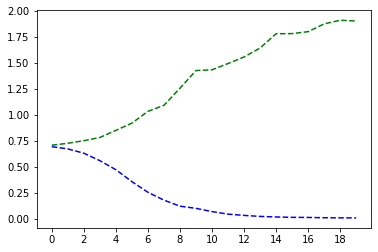

In [ ]:
plt.plot(range(0, 20), losses, '--', color = 'b')
plt.plot(range(0, 20), test_losses, '--', color = 'g')
plt.xticks(np.arange(0, 20, step = 2), np.arange(0, 20, step = 2))
plt.savefig('loss_gru_cue.png', dpi = 400)

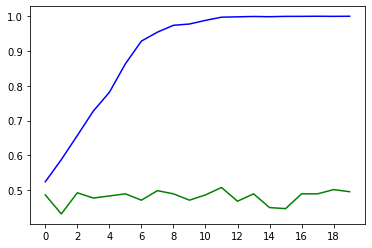

In [ ]:
plt.plot(range(0, 20), accs, color = 'b')
plt.plot(range(0, 20), test_accs, color = 'g')
plt.xticks(np.arange(0, 20, step = 2), np.arange(0, 20, step = 2))
plt.savefig('accuracy_gru_cue.png', dpi = 400)